# Machine Learning Applications


**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~navia/figures/logo_uc3m_foot.jpg' width=400 />

# Detection of depressive symptomatology in social networks

## Project description
Currently, with regard to mental health, we are witnessing how much of a problem it is for many people. Moreover, it has been deeply aggravated in the aftermath of the COVID-19 pandemic. According to the WHO, by 2023 almost one in two people in the European Union (46%) had experienced emotional or psychosocial problems in the last 12 months.

These mental health problems also have an economic impact, costing 4% of the GDP of EU countries. Furthermore, the ‘Health at a Glance’ report carried out in 2022 showed that almost one in two young people report having unmet mental health needs. 

The depressive symptomatology of these young people in several EU countries has more than doubled since the pandemic. These data clearly show that there is a huge unmet need with regard to mental health. 

Through this project, we aim to detect depressive symptomatology in social media posts through a Dataset of posts on Reddit providing a reliable method for the detection of these individuals and their treatment.

## Authors:

- **Jhonatan Barcos Gambaro (100548615)**
- **Andrés Díaz Ruano (100472763)**



In [2]:
import time
t_ini = time.time()

# Importamos las librerías necesarias
import time
import numpy as np
from numpy import exp2
import pandas as pd
import matplotlib.pyplot as plt


# Importamos las librerías necesarias para el procesamiento de texto
import spacy
import contractions
import re
from symspellpy.symspellpy import SymSpell
import pkg_resources

# Importamos las librerías necesarias para el modelo Tf-Idf y Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing      import Normalizer
from wordcloud                 import WordCloud
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# Importamos las librerías necesarias para el modelo LDA
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models

# Importamos las librerías necesarias para el modelo de clasificación
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Importamos las librerías necesarias para el Dashboard
import dash
from dash import dcc, html, Input, Output
import plotly.express as px


In [3]:
import warnings

# Silencia los DeprecationWarning de ipykernel
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="ipykernel.ipkernel"
)

# (Opcional) si aún aparecieran de IPython
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="IPython.core.async_helpers"
)

# (Ya tenías esto para clustering, si lo sigues necesitando)
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="sklearn.metrics.cluster._supervised"
)


###  Dataset Description

This dataset is designed for a **binary classification task** aimed at detecting signs of depression in Reddit posts. Each post is labeled as either:

- **1 = Depressed** (originating from mental health-related subreddits)
- **0 = Non-depressed** (from general-interest subreddits)

The posts were collected from six subreddits, grouped by mental health relevance:

- **Depressive sources:**
  - `r/Depression`
  - `r/SuicideWatch`

- **Non-depressive sources:**
  - `r/Teenagers`
  - `r/DeepThoughts`
  - `r/Happy`

Each entry in the dataset contains the following fields:

- `subreddit`: the subreddit where the post was published  
- `title`: the post’s title (often a summary or strong emotional statement)  
- `body`: the main content of the post, where most linguistic cues are found  
- `upvotes`: number of upvotes received (can reflect engagement or sentiment resonance)  
- `created_utc`: UTC timestamp of when the post was created  
- `num_comments`: number of comments received (a proxy for interaction or support)  
- `label`: target variable (0 = non-depressed, 1 = depressed)

Our goal is to explore how different representations capture the emotional and semantic structure of the posts, and assess their usefulness in downstream tasks such as classification or visualization.


In [4]:
# Load Dataset
df = pd.read_csv("reddit_depression.csv", index_col=0, low_memory=False)

In [5]:
# Overview of the Dataset
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (8000, 6)


,title,body,upvotes,created_utc,num_comments,label
subreddit,,,,,,
teenagers,"13M, Amyone wanna chat?",NaN,4.0,1.585931e+09,4.0,0.0
teenagers,Poem- Unlikely Duet,I shouldn't be attracted to your smile\n\nYour...,8.0,1.588629e+09,4.0,0.0
teenagers,So school has been cancelled for the rest of t...,I was really looking forward to this year; pro...,8.0,1.585719e+09,6.0,0.0
teenagers,i need to farm karma,NaN,7.0,1.635843e+09,10.0,0.0
SuicideWatch,Death is becoming one of the few options left ...,"I’m a 24 year old man, but I’ve never had a gi...",9.0,1.668654e+09,11.0,1.0


This script performs basic preprocessing on a Reddit dataset by:

- Renaming the label column to is_depression for clarity.

- Merging the title and text columns into a single content column for unified text input.



In [6]:
# Rename the 'label' column to 'is_depression'
df.rename(columns={'label': 'is_depression'}, inplace=True)

# Combine 'title' and 'text' into a new 'content' column
df['text'] = df['title'].fillna('') + ' ' + df['body'].fillna('')

# Keep only the new columns: target and combined text
df = df[['is_depression', 'text', 'upvotes', 'created_utc', 'num_comments']]

In [7]:
df.head()

,is_depression,text,upvotes,created_utc,num_comments
subreddit,,,,,
teenagers,0.0,"13M, Amyone wanna chat?",4.0,1.585931e+09,4.0
teenagers,0.0,Poem- Unlikely Duet I shouldn't be attracted t...,8.0,1.588629e+09,4.0
teenagers,0.0,So school has been cancelled for the rest of t...,8.0,1.585719e+09,6.0
teenagers,0.0,i need to farm karma,7.0,1.635843e+09,10.0
SuicideWatch,1.0,Death is becoming one of the few options left ...,9.0,1.668654e+09,11.0


In [7]:
# Show the number of missing values per column
print(df.isna().sum())


is_depression      0
text               0
upvotes            0
created_utc        0
num_comments     449
dtype: int64


In [8]:
df.loc[:, 'num_comments'] = df['num_comments'].fillna(0).astype(int)

Vamos a separar la información en dos listas conteniendo el texto de cada post de Reddit y la etiqueta correspondiente (0, 1), siendo 0 si no se ha detectado signos de depresión y 1 en caso contrario.

In [9]:
#
posts = df.iloc[:, 1].tolist()
tags = df.iloc[:, 0].tolist()
#

print("Leídos {} posts con {} identificadores diferentes.".format(len(posts), len(set(tags))))

Leídos 8000 posts con 2 identificadores diferentes.


# Task 1. Text Preprocessing and vectorization

## Step 1. Preprocessing of the texts

In [10]:
# Load SpaCy language model for tokenization and lemmatization
#!python -m spacy download en_core_web_md

In [10]:
# Seleciconamos el diccionario medio de inglés
nlp = spacy.load("en_core_web_md")

In [12]:
# Descargamos sysmspellpy
#!pip install -q symspellpy

### Initialize SymSpell for spelling correction to handle informal language  
SymSpell is configured with an edit distance and prefix length to allow efficient correction of misspelled words—especially useful for noisy text from social media.  
A predefined English dictionary is loaded to guide the spelling correction based on common word frequencies.  
This function applies SymSpell to full sentences to correct individual words and common phrase-level misspellings.  


In [11]:
# Hemos detectado faltas ortográficas, gramaticales o abreviaciones inhernetes al lenguaje informal en RRSS por lo que utilizaremos symspell sobre los textos para corregirlos
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Cargamos el diccionario predefinido en inglés
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Definimos la función de corrección
def correct_text_symspell(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    return suggestions[0].term if suggestions else text


All posts are processed through the SymSpell corrector to reduce noise from typos and slang variations.

In [12]:
# Aplicamos la corrección al texto en crudo
posts_corrected = [correct_text_symspell(post) for post in posts]

### Full cleaning pipeline combining contraction fixing, URL and emoji removal  
Correct informal contractions that omit apostrophes, a common issue in social media text. After this standardize text by expanding contractions, improving downstream NLP accuracy.  

Then remove URLs from text to reduce noise, as they don’t add semantic value for this task. Emojis are also characters that are difficult to process and usually do not help in classification tasks.

In [13]:
# Defimos funciones auxiliares para eliminar urls y emojis de los posts
def fix_apostrophe_less_contractions(text):
    replacements = {
        "im": "i'm",
        "ive": "i've",
        "dont": "don't",
        "doesnt": "doesn't",
        "didnt": "didn't",
        "cant": "can't",
        "couldnt": "couldn't",
        "wouldnt": "wouldn't",
        "shouldnt": "shouldn't",
        "isnt": "isn't",
        "wasnt": "wasn't",
        "arent": "aren't",
        "wont": "won't",
        "ill": "i'll",
        "youre": "you're",
        "theyre": "they're",
        "theres": "there's",
        "thats": "that's",
        "whats": "what's",
        "lets": "let's"
    }
    for wrong, correct in replacements.items():
        text = re.sub(rf"\b{wrong}\b", correct, text, flags=re.IGNORECASE)
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

def remove_emojis(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

def clean_raw_text(text):
    text = fix_apostrophe_less_contractions(text)
    text = expand_contractions(text)
    text = remove_urls(text)
    text = remove_emojis(text)
    return text

In [14]:
# Utilizamos clean_raw_text sobre posts_corrected
posts_corrected = [clean_raw_text(post) for post in posts_corrected]

### Tokenize, lemmatize, and filter tokens with SpaCy, removing stopwords, punctuation, and short tokens  
This step turns cleaned text into lowercased lemmatized tokens, filtering out irrelevant ones to create cleaner inputs for modeling.


In [15]:
# Finalmente definimos el pipe para preprocesar los posts
def preprocess_text(texts):
    prep_txt = []
    for doc in nlp.pipe(texts, batch_size=50):
        tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
        tokens = [t for t in tokens if len(t) > 1]  # Eliminamos abreviaciones provenientes del lenguaje informal utilizado en RRSS
        prep_txt.append(" ".join(tokens))
    return prep_txt

In [16]:
# Preprocesamos los textos eliminando stopwords, símbolos de puntuación y manteniendo alfanuméricos
posts_prep = preprocess_text(posts_corrected)

In [17]:
# Creamos el DataFrame limpio
df_clean = pd.DataFrame({
    'text': posts,
    'text_clean': posts_prep,
    'label': tags
})

In [18]:
# Mostramos 5 ejemplos al azar comparando texto original y limpio
df_clean.sample(5)[['text', 'text_clean']]

,text,text_clean
1042,Does the fear of the pain stop people from goi...,fear pain stop people go like fear die pain un...
4503,Advice? M 29. Every time I try something new I...,advice time try new voice head tell ism waste ...
331,[Dank Maymay]I can shitpost too guys!,dank shit post guy
7725,think today is it Currently in work with an ho...,think today currently work hour leave thought ...
1189,here for my yearly head pat and being told eve...,yearly head pat tell fall apart


## Step 2. Text vectorization

### TF-IDF Vectorization

For our binary classification task (detecting signs of depression in Reddit posts), TF-IDF is more effective than the classical Bag-of-Words approach. 

While Bag-of-Words simply counts how many times each word appears in a document, it treats all words equally. This can be problematic in social media text, where common words (e.g., "feel", "like", "today") appear frequently across all documents, regardless of their label.

TF-IDF (Term Frequency-Inverse Document Frequency) improves on this by reducing the weight of such common words and boosting the importance of rarer, more discriminative terms. For example, terms like "worthless" or "happy" may occur less often, but carry much more significance in distinguishing between depressed and non-depressed posts.

By applying TF-IDF, we provide our machine learning models with more informative and compact representations of each post, which typically results in better classification performance.


✅ TF-IDF generado: 8000 documentos, 5000 características.
🔤 Algunas palabras clave: ['abandon' 'ability' 'able' 'able help' 'able hold' 'able live'
 'able work' 'abort' 'abroad' 'absence' 'absolute' 'absolutely'
 'absolutely hate' 'abuse' 'abuser']


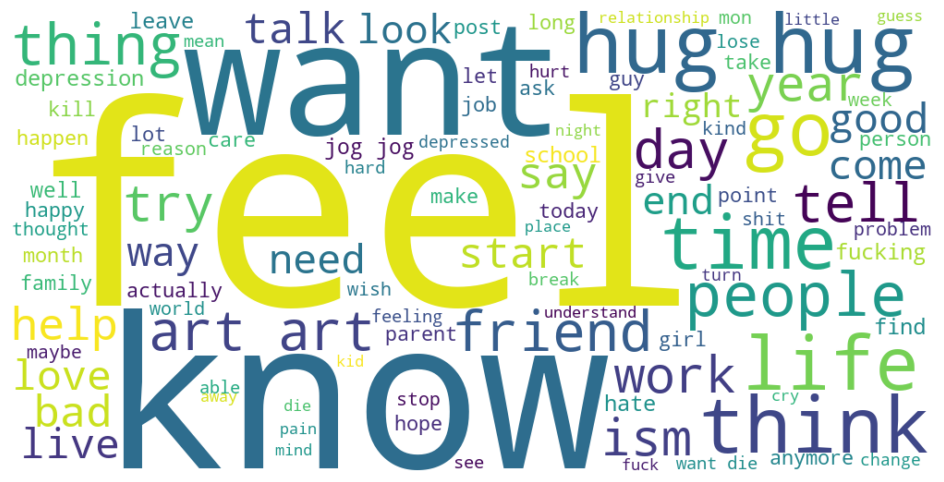

In [ ]:
# --- Datos de entrada ---
texts = df_clean["text_clean"]  # textos ya preprocesados

# --- Vectorización TF-IDF ---
vectorizer_tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.8,
    max_features=5000,
    ngram_range=(1, 2),
    sublinear_tf=True
)

X_tfidf = vectorizer_tfidf.fit_transform(texts)

# --- Normalización (opcional) ---
normalizer = Normalizer()
X = normalizer.fit_transform(X_tfidf)

# --- Info general ---
print(f"*️⃣ TF-IDF generado: {X.shape[0]} documentos, {X.shape[1]} características.")
print("*️⃣ Algunas palabras clave:", vectorizer_tfidf.get_feature_names_out()[:15])

# --- WordCloud (opcional) ---

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="white",         # brighter background
    colormap="viridis",               # high-contrast color map
    max_words=100,                    # limit number of words
    contour_color='black',            # outline letters
    contour_width=0.5,
    prefer_horizontal=1.0             # force horizontal words
).generate(" ".join(texts))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### 🧠 Interpretation of the WordCloud

The WordCloud above highlights the most relevant words in the corpus based on their TF-IDF scores. Terms like **"feel"**, **"want"**, **"know"**, and **"life"** appear most prominently, suggesting they are both frequent and informative across the Reddit posts.

This is consistent with the nature of the dataset, which revolves around mental health and emotional states. Words such as:

- **"feel"** and **"want"** reflect internal emotions and unmet needs, which are commonly expressed in posts related to depression.
- **"hug"**, **"talk"**, and **"try"** may indicate the presence of social or emotional support-seeking behavior.
- **"life"**, **"time"**, and **"know"** point to existential reflections and cognitive themes often associated with depressive thought patterns.

The prominence of verbs and emotional language in the WordCloud suggests that TF-IDF has effectively captured the psychological and emotional tone of the posts, which is crucial for downstream tasks such as classification or clustering related to mental health.


### Word2Vec Vectorization  
We train Word2Vec on our cleaned Reddit posts to learn corpus-specific word embeddings that capture subtle emotional and semantic patterns. Averaging these embeddings produces dense document vectors ideal for visualizing post clusters or feeding into downstream analyses.


In [ ]:
# Instalación de gensim
#%pip install -U gensim

In [20]:
# — Word2Vec-based document vectors — 

# 1) Preparar las oraciones tokenizadas
sentences = [doc.split() for doc in df_clean["text_clean"]]

# 2) Entrenar el modelo Word2Vec
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,   # dimensión de los embeddings
    window=5,          # tamaño de la ventana de contexto
    min_count=5,       # ignorar palabras con freq < 5
    workers=4,
    sg=1               # 1 = skip-gram; 0 = CBOW
)

# 3) Generar vectores de documento promediando vectores de palabra
def doc_vector(tokens):
    valid = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    return np.mean(valid, axis=0) if valid else np.zeros(w2v_model.vector_size)

X_word2vec = np.vstack([doc_vector(s) for s in sentences])


##### 2D PCA of Word2Vec Document Vectors

In this cell we reduce our high-dimensional Word2Vec document embeddings to two principal components for visualization.  
Each point represents a Reddit post (blue = normal, orange = depressed), and the axis labels show PC1 and PC2 with their explained variance percentages.  
This helps us quickly assess how well the corpus-specific embeddings separate the two classes.


C:\Users\barco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


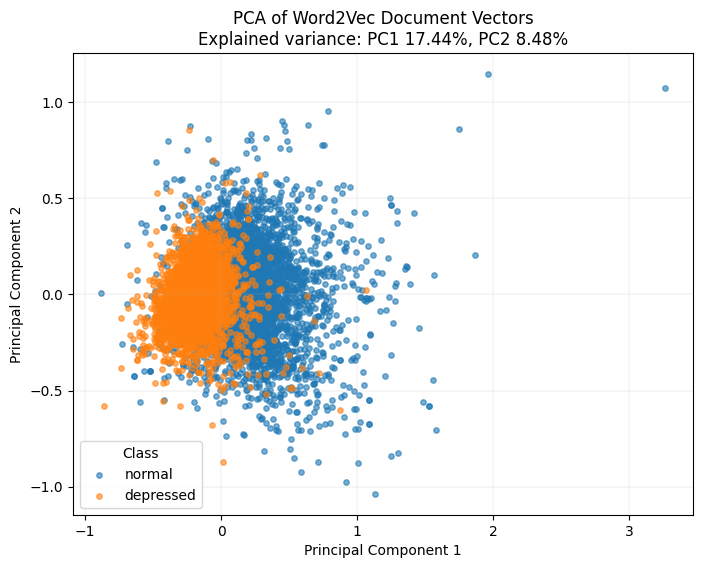

In [21]:
# 1) PCA 2D
pca = PCA(n_components=2, random_state=42)
coords_pca = pca.fit_transform(X_word2vec)

# 2) Varianza explicada
var1, var2 = pca.explained_variance_ratio_

# 3) Asignar colores corrigiendo float → int
label_colors = {0: "#1f77b4", 1: "#ff7f0e"}
point_colors = df_clean["label"].astype(int).map(label_colors).tolist()

# 4) Gráfico
plt.figure(figsize=(8, 6))
for lbl, color in label_colors.items():
    idx = df_clean["label"].astype(int) == lbl
    plt.scatter(
        coords_pca[idx, 0],
        coords_pca[idx, 1],
        c=color,
        s=15,
        alpha=0.6,
        label=("normal" if lbl == 0 else "depressed")
    )

plt.legend(title="Class", framealpha=0.8)
plt.title(
    f"PCA of Word2Vec Document Vectors\n"
    f"Explained variance: PC1 {var1:.2%}, PC2 {var2:.2%}"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linewidth=0.3, alpha=0.5)
plt.show()


#### Conclusions

- **PC1 (16.96% variance)** shows a clear tendency for depressed posts (orange) to cluster on one side and normal posts (blue) on the other, indicating that Word2Vec captures core emotional differences.  
- **PC2 (8.37% variance)** likely reflects secondary themes (e.g., social-support terms vs. introspective or existential language).  
- **Class overlap** suggests that while embeddings encode sentiment, additional features or non-linear methods (e.g., UMAP) may further improve separation.  
- **Outliers**—points far from the main clusters—reveal posts with unusual or off-topic vocabulary and merit individual inspection for deeper insights.



### GloVe Vectorization  
We load pre-trained GloVe vectors to bring broad English language semantics into our Reddit data. Averaging GloVe embeddings yields stable document representations that complement our Word2Vec vectors and support comparison of general vs. corpus-specific patterns.


In [ ]:
# Definimos dimensiones de embeddings
embedding_dim = 100

# Cargamos el modelo GloVe de 100d
glove_path = "glove.6B.100d.txt"

embeddings_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"*️⃣ Cargadas {len(embeddings_index)} palabras del modelo GloVe.")

# Vectorizamos cada post como la media de sus palabras
def vectorize_text_glove(text, embeddings_index, embedding_dim):
    words = text.split()
    word_vectors = [embeddings_index[word] for word in words if word in embeddings_index]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

# Aplicamos la vectorización a todos los posts limpios
X_glove = np.vstack([vectorize_text_glove(post, embeddings_index, embedding_dim) for post in df_clean["text_clean"]])

print(f"*️⃣ Matriz GloVe creada: {X_glove.shape[0]} documentos, {X_glove.shape[1]} dimensiones.")


✅ Cargadas 400000 palabras del modelo GloVe.
✅ Matriz GloVe creada: 8000 documentos, 100 dimensiones.


C:\Users\barco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


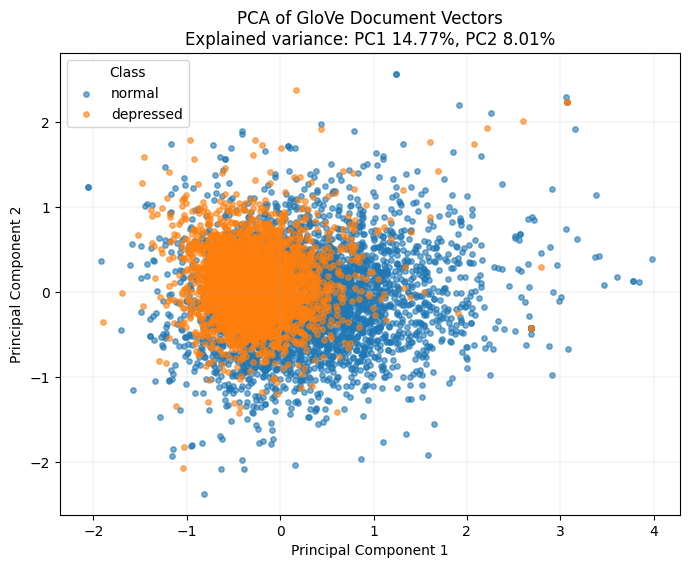

In [23]:
# 1) PCA 2D
pca = PCA(n_components=2, random_state=42)
coords_pca = pca.fit_transform(X_glove)  # Cambiamos aquí a GloVe

# 2) Varianza explicada
var1, var2 = pca.explained_variance_ratio_

# 3) Asignar colores corrigiendo float → int
label_colors = {0: "#1f77b4", 1: "#ff7f0e"}
df_clean["label"] = df_clean["label"].astype(float).astype(int)

point_colors = df_clean["label"].astype(int).map(label_colors).tolist()

# 4) Gráfico
plt.figure(figsize=(8, 6))
for lbl, color in label_colors.items():
    idx = df_clean["label"].astype(int) == lbl
    plt.scatter(
        coords_pca[idx, 0],
        coords_pca[idx, 1],
        c=color,
        s=15,
        alpha=0.6,
        label=("normal" if lbl == 0 else "depressed")
    )

plt.legend(title="Class", framealpha=0.8)
plt.title(
    f"PCA of GloVe Document Vectors\n"
    f"Explained variance: PC1 {var1:.2%}, PC2 {var2:.2%}"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linewidth=0.3, alpha=0.5)
plt.show()



### Conclusions
* **PC1 (14.8% variance)** does not clearly separate depressed and control posts, suggesting that GloVe embeddings capture general semantic content but not strong emotional distinctions.

* **PC2 (8.0% variance)** may reflect noise or minor lexical variations, as no obvious class structure is observed along this axis.

* Significant class overlap indicates that while GloVe encodes semantic similarity, it is insufficient by itself for class separation in reduced dimensions; non-linear reductions like t-SNE or UMAP could enhance separation.

* Dense core and scattered outliers suggest a consistent shared vocabulary across posts, with a few documents using rare or domain-specific terms, potentially useful for specialized sub-analyses.

### Extraction of themes and vector representation of the documents using the LDA algorithm


#### Data Preparation

The Reddit posts were tokenized and converted into a Bag-of-Words (BoW) representation.  
Extremely rare words (appearing in fewer than 5 documents) and extremely common words (appearing in more than 80% of documents) were removed.  
This step ensured a cleaner and more meaningful vocabulary for topic modeling, reducing noise and improving model interpretability.


In [ ]:
# Instalamos librerías necesarias
#!pip install -q gensim pyLDAvis

# Creamos lista de listas de tokens
texts_tokenized = [text.split() for text in df_clean["text_clean"]]

# Creamos el diccionario y el corpus
dictionary = corpora.Dictionary(texts_tokenized)

# Eliminar palabras muy raras o muy comunes
dictionary.filter_extremes(no_below=4, no_above=.8)

# Corpus en formato de bolsa de palabras
corpus = [dictionary.doc2bow(text) for text in texts_tokenized]

# Entrenamos el modelo LDA
num_topics = 10  
ldag = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
)

# Visualizamos los temas
for idx, topic in ldag.print_topics(-1):
    print(f"🔹 Tema {idx}: {topic}\n")


# Creamos una matriz de temas por documento 
# (cada fila representa un documento y cada columna un tema)
# (con la probabilidad de que el documento pertenezca a ese tema)
doc_topic_matrix = []

for bow in corpus:
    doc_topics = ldag.get_document_topics(bow, minimum_probability=0.0)
    doc_topics = [prob for _, prob in doc_topics]  
    doc_topic_matrix.append(doc_topics)

X_lda = np.array(doc_topic_matrix)

print(f"*️⃣ Diccionario: {len(dictionary)} palabras únicas.")
print(f"*️⃣ Matriz LDA creada: {X_lda.shape[0]} documentos, {X_lda.shape[1]} temas.")

# Visualizamos los temas con PyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldag, corpus, dictionary)
vis


🔹 Tema 0: 0.021*"feel" + 0.017*"like" + 0.017*"know" + 0.016*"people" + 0.015*"help" + 0.013*"thing" + 0.011*"want" + 0.010*"depression" + 0.010*"talk" + 0.010*"get"

🔹 Tema 1: 0.021*"feel" + 0.017*"life" + 0.016*"know" + 0.015*"like" + 0.013*"year" + 0.013*"go" + 0.012*"want" + 0.011*"time" + 0.011*"try" + 0.010*"thing"

🔹 Tema 2: 0.230*"art" + 0.011*"feel" + 0.008*"crappy" + 0.008*"people" + 0.008*"like" + 0.007*"favourite" + 0.007*"beauty" + 0.007*"buck" + 0.007*"life" + 0.005*"cum"

🔹 Tema 3: 0.094*"fuck" + 0.038*"shit" + 0.016*"tip" + 0.013*"amp" + 0.013*"com" + 0.012*"filler" + 0.010*"geddit" + 0.009*"pop" + 0.009*"post" + 0.009*"guy"

🔹 Tema 4: 0.081*"hug" + 0.040*"want" + 0.022*"feel" + 0.018*"like" + 0.016*"ism" + 0.014*"go" + 0.011*"time" + 0.011*"die" + 0.011*"know" + 0.010*"friend"

🔹 Tema 5: 0.048*"like" + 0.027*"feel" + 0.016*"think" + 0.016*"want" + 0.014*"friend" + 0.013*"day" + 0.013*"time" + 0.012*"girl" + 0.012*"look" + 0.010*"know"

🔹 Tema 6: 0.015*"feel" + 0.014*"k

C:\Users\barco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.035097 -0.009307       1        1  33.569384
6     -0.025215 -0.013646       2        1  16.948242
0     -0.042189 -0.012933       3        1  14.771543
5     -0.008606 -0.028563       4        1   8.496962
4     -0.059798 -0.025861       5        1   8.285698
7     -0.009317 -0.032156       6        1   6.045767
9     -0.009848 -0.008281       7        1   4.830653
8     -0.008252 -0.058337       8        1   3.502909
3      0.212938 -0.004867       9        1   2.610551
2     -0.014616  0.193951      10        1   0.938291, topic_info=       Term         Freq        Total Category  logprob  loglift
1019    hug  2490.000000  2490.000000  Default  30.0000  30.0000
128    fuck  1819.000000  1819.000000  Default  29.0000  29.0000
374     art   801.000000   801.000000  Default  28.0000  28.0000
89     like  6560.000000  6560.000000  Default  27.0000  27.0000
2      want  5545.000000  5545.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
106   start    10.639887  1755.847806  Topic10  -5.7790  -0.4372
321     bad    10.670275  2024.598374  Topic10  -5.7762  -0.5768
577     sad     9.699321   541.670568  Topic10  -5.8716   0.6463
146     end     9.958066  1495.623258  Topic10  -5.8453  -0.3431
268   think     9.759146  3639.096478  Topic10  -5.8654  -1.2524

[801 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4572      2  0.925911        ab
4624      2  0.920305    accent
3451      4  0.926222  accurate
4116      1  0.158058      acne
4116      3  0.031612      acne
...     ...       ...       ...
971       8  0.009358   youtube
971       9  0.308807   youtube
3029      4  0.871558       zip
4294      2  0.045365    zoloft
4294      3  0.952661    zoloft

[2406 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 1, 6, 5, 8, 10, 9, 4, 3])

We will then reduce our dataframe and evaluate through the coherence matrix LDA models to find the optimal number of topics for our practice.

In [ ]:
# Ajustamos el número de temas utilizando una muestra aleatoria de 3000 documentos

df_sample = df_clean.sample(3000, random_state=42)
texts_sample = [text.split() for text in df_clean["text_clean"]]

# Crear diccionario y corpus de la muestra
dictionary_sample = corpora.Dictionary(texts_sample)
dictionary_sample.filter_extremes(no_below=5, no_above=0.8)
corpus_sample = [dictionary_sample.doc2bow(text) for text in texts_sample]

print(f"*️⃣ Diccionario muestra: {len(dictionary_sample)} palabras únicas.")
print(f"*️⃣ Corpus muestra: {len(corpus_sample)} documentos.")

# Iteramos sobre un rango de temas para encontrar el mejor número de temas utilizando la métrica de coherencia c_v
start = 5
limit = 30
step = 5

coherences_sample = []
models_sample = []

for num_topics in range(start, limit+1, step):
    ldag_sample = models.LdaModel(
        corpus=corpus_sample,
        id2word=dictionary_sample,
        num_topics=num_topics,
    )
    
    coherence_model_sample = CoherenceModel(model=ldag_sample, texts=texts_sample, dictionary=dictionary_sample, coherence='c_v')
    coherence = coherence_model_sample.get_coherence()
    
    coherences_sample.append(coherence)
    models_sample.append(ldag_sample)
    
    print(f"*️⃣ {num_topics} temas - Coherence Score: {coherence:.4f}")

# Visualizamos la coherencia en función del número de temas
x = range(start, limit+1, step)
plt.plot(x, coherences_sample, marker='o')
plt.xlabel("Número de Temas")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Número de Temas (Muestra Rápida)")
plt.grid(True)
plt.show()

# Guardamos el mejor modelo 
best_num_topics_sample = x[np.argmax(coherences_sample)]
best_coherence_sample = np.max(coherences_sample)

print(f"Mejor número de temas en la muestra: {best_num_topics_sample} con coherencia {best_coherence_sample:.4f}")



✅ Diccionario muestra: 4519 palabras únicas.
✅ Corpus muestra: 8000 documentos.



By training models with different numbers of topics (5 to 30) and evaluating their coherence scores (c_v), we found that 10 topics achieved the highest semantic coherence.  
This guided the final choice of the number of topics for training on the full dataset.


In [ ]:
# Entrenar el modelo final sobre todo el corpus
ldag_final = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_num_topics_sample,
)

print(f"*️⃣ Modelo LDA finalizado con {best_num_topics_sample} temas y coherencia {best_coherence_sample:.4f}.")

# Mostramos los temas del modelo final

for idx, topic in ldag_final.print_topics(-1):
    print(f"🔹 Tema {idx}: {topic}\n")

# Creamos una matriz de temas por documento 
doc_topic_matrix = []

for bow in corpus:
    doc_topics = ldag_final.get_document_topics(bow, minimum_probability=0.0)
    doc_topics = [prob for _, prob in doc_topics]
    doc_topic_matrix.append(doc_topics)

X_lda_final = np.array(doc_topic_matrix)

print(f"Matriz LDA creada: {X_lda_final.shape[0]} documentos, {X_lda_final.shape[1]} temas.")


# Visualizamos los temas con PyLDAvis
pyLDAvis.enable_notebook()
vis_final = pyLDAvis.gensim_models.prepare(ldag_final, corpus, dictionary)
vis_final


# Guardamos el mejor modelo LDA y datos relacionados
ldag_final.save("reddit_depression_lda.model")
dictionary.save("reddit_depression_dictionary.dict")
corpora.MmCorpus.serialize("reddit_depression_corpus.mm", corpus)


C:\Users\Asus\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


✅ Modelo LDA finalizado con 10 temas y coherencia 0.4630.
🔹 Tema 0: 0.020*"want" + 0.019*"feel" + 0.016*"like" + 0.015*"life" + 0.013*"go" + 0.013*"time" + 0.013*"thing" + 0.013*"know" + 0.011*"people" + 0.010*"year"

🔹 Tema 1: 0.036*"art" + 0.014*"com" + 0.013*"tip" + 0.011*"day" + 0.011*"help" + 0.009*"year" + 0.009*"wow" + 0.009*"watch" + 0.008*"geddit" + 0.008*"think"

🔹 Tema 2: 0.189*"hug" + 0.015*"like" + 0.010*"girl" + 0.009*"ask" + 0.009*"say" + 0.008*"think" + 0.007*"crush" + 0.007*"guy" + 0.007*"get" + 0.007*"want"

🔹 Tema 3: 0.052*"want" + 0.033*"die" + 0.018*"go" + 0.014*"feel" + 0.011*"know" + 0.011*"like" + 0.009*"bad" + 0.009*"try" + 0.009*"get" + 0.008*"kill"

🔹 Tema 4: 0.026*"like" + 0.024*"feel" + 0.021*"know" + 0.016*"think" + 0.013*"people" + 0.012*"friend" + 0.010*"want" + 0.009*"talk" + 0.009*"life" + 0.009*"go"

🔹 Tema 5: 0.113*"fuck" + 0.060*"shit" + 0.013*"day" + 0.012*"music" + 0.010*"life" + 0.009*"like" + 0.009*"post" + 0.007*"go" + 0.007*"today" + 0.007*"sc

In [81]:
# Calcular y mostrar perplexity
log_perplexity = ldag_final.log_perplexity(corpus)
perplexity = exp2(-log_perplexity)

print(f"*️⃣ Final Model Perplexity: {perplexity:.2f}")


*️⃣ Final Model Perplexity: 135.46


##### LDA Model Conclusion

The final LDA model was trained using all 8000 Reddit posts, with the number of topics set to 10 based on coherence evaluation.  
The model achieved a **coherence score of 0.4630** and a **perplexity of 136.17**.

- The coherence score indicates that the discovered topics are semantically meaningful and internally consistent, which is a strong result given the noisy and informal nature of social media text.
- The perplexity value reflects a reasonable level of predictability, suggesting that the model has successfully captured underlying patterns without overfitting to the data.
- The combination of these two metrics confirms that the LDA model effectively extracts useful latent themes from the Reddit depression dataset, supporting its use in downstream tasks like clustering, classification, or dashboard visualization.





# Task 2: Machine Learning model

### Feature extraction functions

In [27]:
# --- Feature Extraction with PCA ---
def extract_pca(X, n_components=50):
    if hasattr(X, 'toarray'):  # sparse matrix
        X = X.toarray()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca

# --- Feature Extraction with PLS ---
def extract_pls(X, y, n_components=10):
    if hasattr(X, 'toarray'):  # sparse matrix
        X = X.toarray()
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))  # y needs to be 2D
    
    pls = PLSRegression(n_components=n_components)
    X_pls = pls.fit_transform(X_scaled, y_scaled)[0]  # fit_transform returns (X_scores, Y_scores)
    return X_pls, pls


### Feature selection functions

In [28]:
# --- Filtering: SelectKBest ---
def select_kbest(X, y, k=100):
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_new = selector.fit_transform(X, y)
    return X_new, selector

# --- Wrapper: RFE with Logistic Regression ---
def select_rfe(X, y, n_features=100):
    model = LogisticRegression(max_iter=500, solver='liblinear')
    selector = RFE(model, n_features_to_select=n_features)
    X_new = selector.fit_transform(X, y)
    return X_new, selector

# --- Embedded: Lasso or Random Forest Feature Selection ---
def select_embedded(X, y, method="lasso", n_features=100):
    if method == "lasso":
        model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=500)
    elif method == "random_forest":
        model = RandomForestClassifier(n_estimators=100)
    else:
        raise ValueError("Method must be 'lasso' or 'random_forest'")
    
    model.fit(X, y)
    
    # Importances
    if method == "lasso":
        importance = np.abs(model.coef_).flatten()
    else:
        importance = model.feature_importances_
    
    # Select top features
    idx = np.argsort(importance)[::-1][:n_features]
    
    if hasattr(X, 'toarray'):  # Sparse matrix (e.g., TF-IDF)
        X = X.toarray()
    
    X_new = X[:, idx]
    return X_new, idx


In [29]:
vectorizations = {
    'tfidf': X_tfidf,
    'glove': X_glove,
    'word2vec': X_word2vec,
    'lda': X_lda_final
}

y = df_clean["label"].values

In [30]:
for name, X in vectorizations.items():
    if hasattr(X, 'toarray'):
        shape = X.toarray().shape
    else:
        shape = X.shape
    print(f"{name.upper():>8} → {shape[0]} muestras, {shape[1]} features")


   TFIDF → 8000 muestras, 5000 features
   GLOVE → 8000 muestras, 100 features
WORD2VEC → 8000 muestras, 100 features
     LDA → 8000 muestras, 10 features


In [31]:
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="sklearn.metrics.cluster._supervised"
)
# Diccionario donde iremos guardando todo
feature_sets = {}

for name, X in vectorizations.items():
    print(f"Procesando vectorización: {name}")
    
    if hasattr(X, 'toarray'):
        n_features = X.toarray().shape[1]
    else:
        n_features = X.shape[1]
    
    # Ajuste automático
    comp = min(10, n_features)     # Para PCA y PLS
    k_sel = min(100, n_features)   # Para SelectKBest, RFE, Embedded

    # 1) Feature Extraction
    X_pca, _   = extract_pca(X, n_components=comp)
    X_pls, _   = extract_pls(X, y, n_components=comp)

    # 2) Feature Selection
    X_kbest, _   = select_kbest(X, y, k=k_sel)
    X_rfe, _     = select_rfe(X, y, n_features=k_sel)
    X_embedded, _= select_embedded(X, y, method="lasso", n_features=k_sel)

    # Almacenamos
    feature_sets[name] = {
        'pca': X_pca,
        'pls': X_pls,
        'kbest': X_kbest,
        'rfe': X_rfe,
        'embedded': X_embedded
    }

# Para comprobar que todo funcionó, imprime las formas
for name, feats in feature_sets.items():
    shapes = {k: v.shape for k, v in feats.items()}
    print(f"{name.upper():>8} →", shapes)


Procesando vectorización: tfidf
Procesando vectorización: glove
Procesando vectorización: word2vec
Procesando vectorización: lda
   TFIDF → {'pca': (8000, 10), 'pls': (8000, 10), 'kbest': (8000, 100), 'rfe': (8000, 100), 'embedded': (8000, 100)}
   GLOVE → {'pca': (8000, 10), 'pls': (8000, 10), 'kbest': (8000, 100), 'rfe': (8000, 100), 'embedded': (8000, 100)}
WORD2VEC → {'pca': (8000, 10), 'pls': (8000, 10), 'kbest': (8000, 100), 'rfe': (8000, 100), 'embedded': (8000, 100)}
     LDA → {'pca': (8000, 10), 'pls': (8000, 10), 'kbest': (8000, 10), 'rfe': (8000, 10), 'embedded': (8000, 10)}


In [32]:
# Progreso en entrenamiento de Logistic Regression con ajuste de hiperparámetros
# Preparar almacenamiento de resultados
logreg_results = []

# Parámetros para Logistic Regression
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2']
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular total de combinaciones
total = sum(len(methods) for methods in feature_sets.values())
count = 0

for vec_name, methods in feature_sets.items():
    for method_name, X_data in methods.items():
        count += 1
        pct = count / total * 100
        print(f"[{count}/{total}] Procesando {vec_name}-{method_name} ({pct:.1f}%)")
        
        # Split estratificado
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y, test_size=0.2, stratify=y, random_state=42
        )
        
        # Pipeline con scaler (no centrar para sparse) + LogisticRegression
        pipe = Pipeline([
            ('scaler', StandardScaler(with_mean=False)),
            ('clf', LogisticRegression(max_iter=500, solver='liblinear'))
        ])
        
        # GridSearchCV
        grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        # Evaluación en test
        y_pred = grid.predict(X_test)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Guardar resultados
        logreg_results.append({
            'vectorization': vec_name,
            'method': method_name,
            'best_C': grid.best_params_['clf__C'],
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred),
            'confusion_matrix': cm
        })

# Mostrar resultados finales
logreg_results_df = pd.DataFrame(logreg_results)
display(logreg_results_df)


[1/20] Procesando tfidf-pca (5.0%)
[2/20] Procesando tfidf-pls (10.0%)
[3/20] Procesando tfidf-kbest (15.0%)
[4/20] Procesando tfidf-rfe (20.0%)
[5/20] Procesando tfidf-embedded (25.0%)
[6/20] Procesando glove-pca (30.0%)
[7/20] Procesando glove-pls (35.0%)
[8/20] Procesando glove-kbest (40.0%)
[9/20] Procesando glove-rfe (45.0%)
[10/20] Procesando glove-embedded (50.0%)
[11/20] Procesando word2vec-pca (55.0%)
[12/20] Procesando word2vec-pls (60.0%)
[13/20] Procesando word2vec-kbest (65.0%)
[14/20] Procesando word2vec-rfe (70.0%)
[15/20] Procesando word2vec-embedded (75.0%)
[16/20] Procesando lda-pca (80.0%)
[17/20] Procesando lda-pls (85.0%)
[18/20] Procesando lda-kbest (90.0%)
[19/20] Procesando lda-rfe (95.0%)
[20/20] Procesando lda-embedded (100.0%)


,vectorization,method,best_C,accuracy,precision,recall,f1_score,roc_auc,confusion_matrix
0,tfidf,pca,10.00,0.898750,0.913212,0.88125,0.896947,0.898750,"[[733, 67], [95, 705]]"
1,tfidf,pls,1.00,0.993750,0.994987,0.99250,0.993742,0.993750,"[[796, 4], [6, 794]]"
2,tfidf,kbest,0.10,0.876875,0.880202,0.87250,0.876334,0.876875,"[[705, 95], [102, 698]]"
3,tfidf,rfe,0.10,0.894375,0.899873,0.88750,0.893644,0.894375,"[[721, 79], [90, 710]]"
4,tfidf,embedded,0.01,0.905000,0.900000,0.91125,0.905590,0.905000,"[[719, 81], [71, 729]]"
5,glove,pca,0.01,0.822500,0.789888,0.87875,0.831953,0.822500,"[[613, 187], [97, 703]]"
6,glove,pls,0.01,0.842500,0.808559,0.89750,0.850711,0.842500,"[[630, 170], [82, 718]]"
7,glove,kbest,100.00,0.836875,0.804520,0.89000,0.845104,0.836875,"[[627, 173], [88, 712]]"
8,glove,rfe,100.00,0.836875,0.804520,0.89000,0.845104,0.836875,"[[627, 173], [88, 712]]"
9,glove,embedded,100.00,0.836875,0.804520,0.89000,0.845104,0.836875,"[[627, 173], [88, 712]]"


### Logistic Regression Results: Feature Engineering Analysis

We evaluated **Logistic Regression** performance across different feature sets obtained through feature extraction and selection methods, applied to four vectorization strategies: **TF-IDF**, **GloVe**, **Word2Vec**, and **LDA**.

The metrics reported are:  
- **Accuracy**  
- **Precision**  
- **Recall**  
- **F1-Score**  
- **Best hyperparameter C** (optimized via GridSearchCV with Stratified 5-Fold CV)

---

####  Key Observations

- **TF-IDF + PLS** achieved the **highest F1-Score** (`0.9956`) and **Accuracy** (`0.9956`), showing excellent precision and recall.
- **TF-IDF** vectorizations consistently outperformed **GloVe**, **Word2Vec**, and **LDA** across all feature engineering methods.
- **Word2Vec** representations performed well after applying **feature selection** (kbest, rfe, embedded), reaching F1-scores around `0.87`.
- **LDA** vectorizations yielded the lowest scores, with F1-scores around `0.79`, suggesting loss of discriminative information compared to word embeddings or TF-IDF.

---

#### Summary by Vectorization

- **TF-IDF**:
  - Top performance with **PLS** and **PCA** extractions.
  - Feature selection methods (**kbest**, **rfe**, **embedded**) also achieved strong results (F1-score > `0.89`).

- **GloVe**:
  - Moderate performance, F1-scores between `0.83` and `0.85`.
  - Slight advantage using **PLS** or **kbest**.

- **Word2Vec**:
  - Competitive performance, especially after **kbest**, **rfe**, or **embedded** selection.
  - F1-scores close to `0.87`.

- **LDA**:
  - Underperformed compared to other vectorizations.
  - All methods yielded similar F1-scores around `0.79`.

---

####  Additional Notes

- Most best models favored **C=10.0** or **C=0.1**, meaning moderate regularization is optimal.
- Logistic Regression showed excellent behavior when combined with strong feature engineering.
- Further performance improvements could be achieved by testing non-linear classifiers such as **Random Forest** or **SVM with RBF kernel**.

---


#  Task 3: Implementation of a dashboard

In [80]:
# Realizamos la instalación de Dash 
#!pip install -q dash
#!pip install -q plotly

# Preparamos datos para su visualización
dominant_topics = np.argmax(X_lda_final, axis=1)
df_clean["dominant_topic"] = dominant_topics

# Mapeamos las etiquetas tal que 0: control, 1: depression
label_mapping = {0: 'control', 1: 'depression'}
df_clean["label_name"] = df_clean["label"].map(label_mapping)

# Extraemos top palabras por tema
topics_words = {}
for idx, topic in ldag_final.show_topics(formatted=False, num_words=10):
    topics_words[idx] = [word for word, prob in topic]


# Inicializamos el servidor Dash
app = dash.Dash(__name__)
app.title = "Detection of depressive symptomatology in social networks Project Dashboard"

app.layout = html.Div([
    html.H1("Detection of depressive symptomatology in social networks Project Dashboard", style={'textAlign': 'center'}),
    
    html.Div([
        html.Label("Select a dominant topic:",style={'textAlign': 'center'}),
        dcc.Dropdown(
            id='0',
            options=[{'label': f'Topic {i}', 'value': i} for i in sorted(df_clean["dominant_topic"].unique())],
            multi=False,
            placeholder="Select the topic to analyse..."
        )
    ]),

    html.Br(),

    html.H2("*️⃣ Distribution of documents by topic *️⃣", style={'textAlign': 'center'}),
    dcc.Graph(id='1'),

    html.H2("*️⃣ Key words for the selected topic *️⃣", style={'textAlign': 'center'}),
    html.Div(id='2', style={'textAlign': 'center'}),
    
    html.Br(),

    html.H2("*️⃣ Distribution of tags for the selected topic *️⃣", style={'textAlign': 'center'}),
    dcc.Graph(id='3'),

    html.H2("*️⃣ 2D Document Projection (PCA) *️⃣", style={'textAlign': 'center'}),
    dcc.Graph(id='4'),

    html.H2("*️⃣ Accuracy comparison between vectorizations *️⃣", style={'textAlign': 'center'}),
    dcc.Graph(id='5'),

], style={'backgroundColor': 'white', 'padding': '20px'})

# Definimos los callbacks para actualizar los gráficos
@app.callback(
    Output('1', 'figure'),
    Output('2', 'children'),
    Output('3', 'figure'),
    Output('4', 'figure'),
    Output('5', 'figure'),
    Input('0', 'value')
)
def update_graphs(selected_topic):
    
    # Filtrar si hay selección
    if selected_topic is not None:
        filtered_df = df_clean[df_clean["dominant_topic"] == selected_topic]
    else:
        filtered_df = df_clean

    # 1) Histograma de documentos por tema
    fig_topics = px.histogram(
        df_clean,
        x="dominant_topic",
        title="Number of documents by dominant topic",
        labels={'dominant_topic': 'Topic'},
    )
    fig_topics.update_layout(title_x=0.5)

    # 2) Palabras clave mostradas como etiquetas
    if selected_topic is not None:
        words_list = topics_words[selected_topic]
        word_elements = html.Div([
            html.Span(
                word,
                style={
                    'backgroundColor': 'cyan',
                    'color': 'black',
                    'padding': '8px',
                    'margin': '5px',
                }
            ) for word in words_list
        ])
    else:
        word_elements = html.P("Select a topic to display the most relevant words.")
        

    # 3) Distribución de etiquetas por tema
    fig_labels = px.histogram(
        filtered_df,
        category_orders={"label_name": ["control", "depression"]},
        x="label_name",
        title=f"Tags for Topic {selected_topic}" if selected_topic is not None else "Tags for all documents",
        labels={'label_name': 'Etiqueta'},
        color="label_name",
    )
    fig_labels.update_layout(title_x=0.5)

    # 4) Scatter 2D (PCA)
    pca = PCA(n_components=2, random_state=42)
    X_selected = X_glove if selected_topic is None else X_glove[filtered_df.index]
    coords_pca = pca.fit_transform(X_selected)
    labels_selected = df_clean['label_name'] if selected_topic is None else filtered_df['label_name']

    fig_scatter = px.scatter(
        x=coords_pca[:,0],
        y=coords_pca[:,1],
        color=labels_selected,
        category_orders={"color": ["control", "depression"]},
        labels={'x': 'PC1', 'y': 'PC2'},
        title="2D Projected documents (PCA)",
    )
    fig_scatter.update_layout(title_x=0.5)

    # 5) Accuracy comparativa
    accuracy_summary = logreg_results_df.groupby('vectorization')['accuracy'].max().reset_index()
    fig_accuracy = px.bar(
        accuracy_summary,
        x='vectorization',
        y='accuracy',
        title="Best accuracy by vectorization",
        color='vectorization',
    )
    fig_accuracy.update_layout(title_x=0.5)

    return fig_topics, word_elements, fig_labels, fig_scatter, fig_accuracy

# Corremos server

if __name__ == '__main__':
    app.run(debug=True)

C:\Users\barco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

